In [11]:
import sys

# Data I/O and numerical imports
import h5py
import numpy as np

# ML imports
import tensorflow as tf
from tensorflow.data import Dataset
from energyflow.archs import EFN, PFN
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# Plotting imports
import matplotlib.pyplot as plt

# Custom imports
import preprocessing

################################# SETTINGS #####################################

# Settings used for data preparation and network training

# Paths to data files - only used test.h5 since train.h5 is 130 GB and couldn't be downloaded in time (thanks Eskom)
train_path = '/Users/samsonthornhill/Documents/UCT/2022/DS/Project/ATLAS-top-tagging-open-data-master/scratch/test.h5'

# Set the amount of data to be used in training and testing
n_train_jets = 3000000

# Set the fraction of the training data which will be reserved for validation
valid_fraction = 1/3

# Training parameters
num_epochs = 10
batch_size = 150

########################### Data Preparation ###################################
print("Read data and prepare for tagger training")

# Load data from files using h5py
train = h5py.File(train_path, 'r')

data_vector_names = train.attrs.get('hl') # high level attributes
data_jet_kin = train.attrs.get('jet') # jet kinematics

# Load data into a python dictionary for pass into pre-processing functions
train_dict = {key: train[key][:n_train_jets,...] for key in data_vector_names} # general train dictionary
train_kin_dict = {key: train[key][:n_train_jets,...] for key in data_jet_kin} # jet kinematics dictionary

# Data shapes: (15)
print("Processing high level quantity information")
train_data = preprocessing.high_level(train_dict)
num_data_features = train_data.shape[-1]

# Load labels, training weights, and jet_pt information for later
train_labels = train['labels'][:n_train_jets]
train_weights = train['weights'][:n_train_jets]
train_pt = train_kin_dict['fjet_pt'][:n_train_jets]

####################### Build Tagger and Datasets  #############################
print("Building tagger and datasets")

# Build hlDNN

# stops training when loss function stops improving for 3 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.001, patience=2) 

# used to track accuracy over one epoch, commented out otherwise
#class BCP(tf.keras.callbacks.Callback):
#    batch_accuracy = [] # accuracy at given batch
#    batch_loss = [] # loss at given batch    
#    def __init__(self):
#        super(BCP,self).__init__() 
#    def on_train_batch_end(self, batch, logs=None):                
#        BCP.batch_accuracy.append(logs.get('accuracy'))
#        BCP.batch_loss.append(logs.get('loss'))


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=train_data.shape[1:]))
    
# Hidden layers
for _ in range(4):
    model.add(tf.keras.layers.Dense(
        20,
        activation='relu',
        kernel_initializer='glorot_uniform')
    )

# Output layer
model.add(tf.keras.layers.Dense(
    1,
    activation='sigmoid',
    kernel_initializer='glorot_uniform')
)

# Compile hlDNN
model.compile(
    optimizer='Adam',
    # from_logits set to False for uniformity with energyflow settings
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

# Make train / valid split using sklearn train_test_split function
(train_data, valid_data, train_labels,
    valid_labels, train_weights, valid_weights, train_pt, valid_pt) = train_test_split(
    train_data,
    train_labels,
    train_weights,
    train_pt,
    test_size=valid_fraction,
    shuffle=True
)

Read data and prepare for tagger training
Processing high level quantity information
Building tagger and datasets


In [12]:
############################### Train Tagger ###################################
print("Starting tagger training")

# Train tagger with keras fit function.
train_history = model.fit(
    train_data,
    train_labels,
    sample_weight=train_weights,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks = [callback],
    #callbacks = [BCP()],
    verbose=1
)

Starting tagger training
Epoch 1/10
11041/11041 [==============================] - 7s 584us/step - loss: 0.3738 - accuracy: 0.8388
Epoch 2/10
11041/11041 [==============================] - 6s 580us/step - loss: 0.3581 - accuracy: 0.8474
Epoch 3/10
11041/11041 [==============================] - 6s 580us/step - loss: 0.3549 - accuracy: 0.8495
Epoch 4/10
11041/11041 [==============================] - 6s 579us/step - loss: 0.3533 - accuracy: 0.8503
Epoch 5/10
11041/11041 [==============================] - 6s 581us/step - loss: 0.3520 - accuracy: 0.8508
Epoch 6/10
11041/11041 [==============================] - 6s 581us/step - loss: 0.3514 - accuracy: 0.8508
Epoch 7/10
11041/11041 [==============================] - 6s 580us/step - loss: 0.3504 - accuracy: 0.8512
Epoch 8/10
11041/11041 [==============================] - 6s 583us/step - loss: 0.3497 - accuracy: 0.8516
Epoch 9/10
11041/11041 [==============================] - 6s 581us/step - loss: 0.3493 - accuracy: 0.8516
Epoch 10/10
11041/110

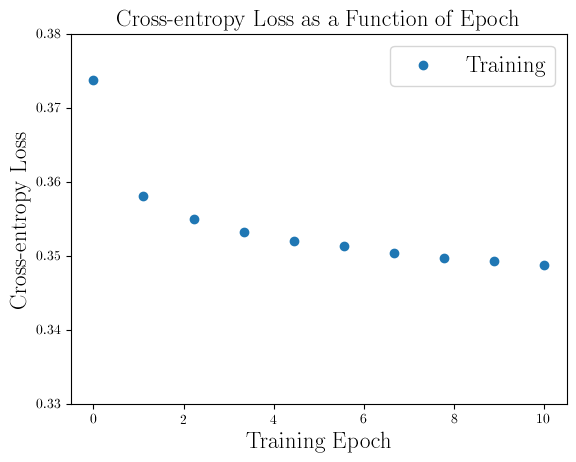

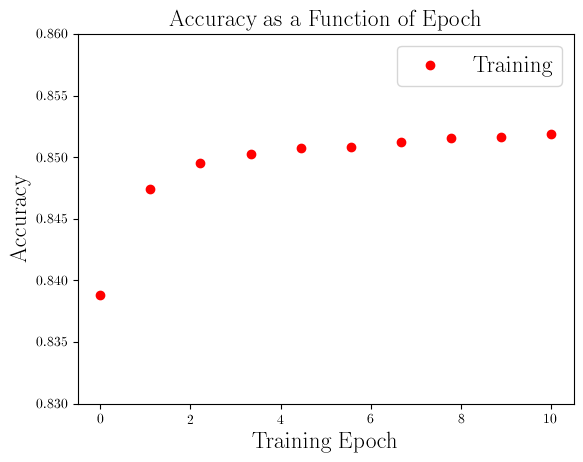

In [13]:
import matplotlib
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.labelsize': 17,
    'axes.titlesize': 17,
    'legend.fontsize': 17
})

# Plot accuracy as a function of batch number for the first epoch
#batch_x = np.linspace(0, len(BCP.batch_accuracy), len(BCP.batch_accuracy))

#plt.scatter(batch_x, BCP.batch_accuracy, marker = '.')
#plt.ylabel('Accuracy')
#plt.xlabel('Batch Number')
#plt.title('Evolution of Accuracy for One Epoch')
#plt.ylim(0.5, 0.9)
#plt.savefig('/Users/samsonthornhill/Documents/UCT/2022/DS/Project/Report/images/epochacc.png', dpi = 300)
#plt.show()
#plt.clf()

# Plot training loss and accuracy against training epochs
x = np.linspace(0, 10, 10)

plt.scatter(x, train_history.history['loss'], label='Training')
plt.ylim(0.33, 0.38)
plt.ylabel('Cross-entropy Loss')
plt.xlabel('Training Epoch')

plt.title('Cross-entropy Loss as a Function of Epoch')
plt.legend()
#plt.savefig('/Users/samsonthornhill/Documents/UCT/2022/DS/Project/Report/images/CEL.png', dpi = 300)
plt.show()

plt.clf()

plt.scatter(x, train_history.history['accuracy'], label='Training', color='r')
plt.ylim(0.83, 0.86)
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')

plt.title('Accuracy as a Function of Epoch')
plt.legend()
#plt.savefig('/Users/samsonthornhill/Documents/UCT/2022/DS/Project/Report/images/acc.png', dpi = 300)
plt.show()


In [14]:
# using validation data to make predictions with the trained model
predictions = model.predict(valid_data, batch_size=batch_size)[:,0]

5521/5521 [==============================] - 1s 250us/step


[[0.85080899 0.14609335]
 [0.14919101 0.85390665]]


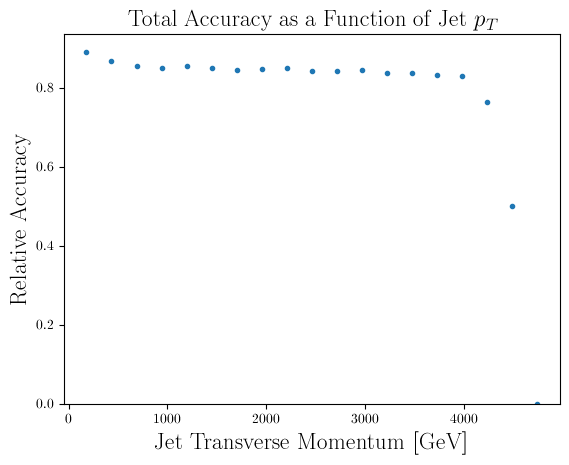

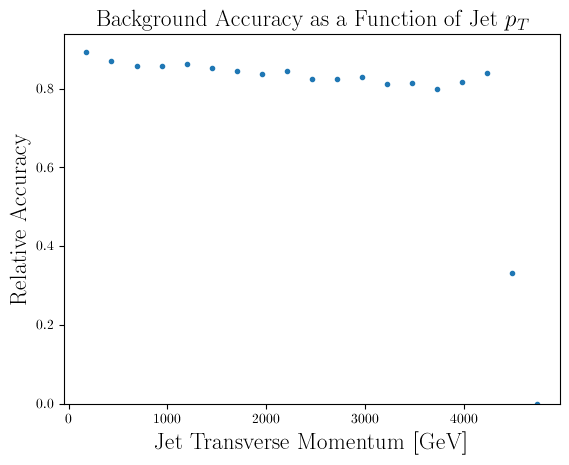

In [29]:
# defining a cut above which we consider the model "successful" and below which we consider the model "unsuccessful"
# changing the cut obviously has effects on the confusion matrix (and on model accuracy as a func of jet pt)

dscr = 0.5

discrete_predictions = (predictions > dscr).astype(int)

from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(valid_labels, discrete_predictions, normalize='pred') # normalising along columns

print(confusion)

pt_bins = np.linspace(180000, 5000000, 20)

# loop which sets the current value to 1 if the NN predicted the data correctly for total accuracy
temp_labels = []
for i in range(0, len(valid_pt)):
    if (valid_labels[i] == 1) and (discrete_predictions[i] == 1):
        temp_labels.append(1)
    elif (valid_labels[i] == 0) and (discrete_predictions[i] == 0):
        temp_labels.append(1)
    else:
        temp_labels.append(0) 

acc_labels = np.array(temp_labels)

# loop which sets the current value to 1 if the NN predicted signal events correctly
temp_labels = []
for i in range(0, len(valid_pt)):
    if (valid_labels[i] == 0) and (discrete_predictions[i] == 0):
        temp_labels.append(1)
    else:
        temp_labels.append(0) 

acc_labels_signal = np.array(temp_labels)

# binning accuracy labels and valid labels according to how pt is binned
acc_binned = [acc_labels[np.where((valid_pt > low) & (valid_pt <= high))] for low, high in zip(pt_bins[:-1], pt_bins[1:])]
acc_binned_signal = [acc_labels_signal[np.where((valid_pt > low) & (valid_pt <= high))] for low, high in zip(pt_bins[:-1], pt_bins[1:])]
valid_binned = [valid_labels[np.where((valid_pt > low) & (valid_pt <= high))] for low, high in zip(pt_bins[:-1], pt_bins[1:])]

# summing labels in each bin
temp_acc = []
for arrays in acc_binned:
    temp_acc.append(np.sum(arrays))

acc = np.array(temp_acc)

temp_acc = []
for arrays in acc_binned_signal:
    temp_acc.append(np.sum(arrays))

acc_signal = np.array(temp_acc)

# binning valid_pt according to pt_bins
binned_pt = np.histogram(valid_pt, pt_bins)
binned_pt_signal = np.histogram(valid_pt[np.where(valid_labels == 0)], pt_bins)

# removing zeros in case the shuffle doesn't capture the one or two events with pT > 5 TeV
if binned_pt[0][-1] == 0:
    binned_pt[0][-1] = 1

if binned_pt_signal[0][-1] == 0:
    binned_pt_signal[0][-1] = 1

# calculating relative accuracy for all events and for just signal
relative_acc = acc/binned_pt[0]
relative_acc_signal = acc_signal/binned_pt_signal[0]

# plotting
plt.plot(pt_bins[0:-1]/1000, relative_acc, '.', label = 'Accuracy')
plt.xlabel('Jet Transverse Momentum [GeV]')
plt.ylabel('Relative Accuracy')
plt.title('Total Accuracy as a Function of Jet $p_T$')
plt.ylim(0.95*np.amin(relative_acc), 1.05*np.amax(relative_acc))
plt.savefig('/Users/samsonthornhill/Documents/UCT/2022/DS/Project/Report/images/relacc2.png', dpi = 300)
plt.show()

plt.clf()

plt.plot(pt_bins[0:-1]/1000, relative_acc_signal, '.', label = 'Accuracy')
plt.xlabel('Jet Transverse Momentum [GeV]')
plt.ylabel('Relative Accuracy')
plt.title('Background Accuracy as a Function of Jet $p_T$')
plt.ylim(0.95*np.amin(relative_acc_signal), 1.05*np.amax(relative_acc_signal))
plt.savefig('/Users/samsonthornhill/Documents/UCT/2022/DS/Project/Report/images/relaccbkg.png', dpi = 300)
#plt.show()

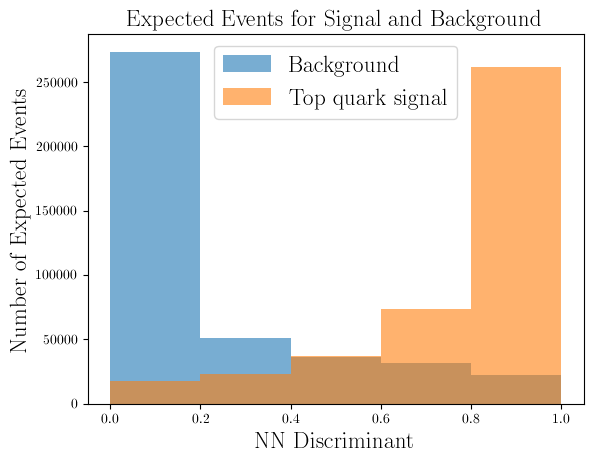

In [39]:
import pandas as pd

dfNN = pd.DataFrame()
dfNN["labels"] = valid_labels
dfNN["predictions"] = predictions
dfNN["weights"] = valid_weights

sigVals = dfNN[dfNN["labels"] == 1]
bkgVals = dfNN[dfNN["labels"] == 0]

bkgHistNN = plt.hist(bkgVals["predictions"], bins = 5, weights = bkgVals["weights"], label = 'Background', alpha = 0.6)
sigHistNN = plt.hist(sigVals["predictions"], bins = 5, weights = sigVals["weights"], label = 'Top quark signal', alpha = 0.6)

plt.xlabel("NN Discriminant")
plt.ylabel("Number of Expected Events")
plt.title("Expected Events for Signal and Background")
plt.legend()

#plt.savefig('/Users/samsonthornhill/Documents/UCT/2022/DS/Project/Report/images/discrNN.png', dpi = 300)
plt.show()
